# Capstone Project: The Battle of Neighborhoods

## Assignment: Where to open a Italian restaurant in Amsterdam
This project is the final assignment of the IBM Professional Data science Certificate. This certificate consists of a series of 10 courses in which data science skills, including Data Science Methodology, data mining and analysis with python has been studied and applied. The main objectives for this project are the following:

Leverage location data provided by Foursquare and the Data of Toronto website
Applying data science skills in machine learning and data visualization
Segmentation and clustering of location data in order to explore neighborhoods to help addressing a business problem
The results will be presented in this Jupyter Notebook as well as in a presentation and a final report published on Github.

### Before we start lets import the libraries needed in this notebook

In [120]:
#Import basic libraries
import pandas as pd #the pandas package
import numpy as np # the numpy package

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # retrieve function used to get the nearby venues
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules vor data visualisation
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage machinelearning
from sklearn.cluster import KMeans

from bs4 import BeautifulSoup
import folium # map rendering library

print("Libraries Imported")

Libraries Imported


# 1. Data Acquisition

## Loading the neighborhood data from the Canada data website
The Canada data website (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) contains postal code and list of the Canadian boroughs. The data is extracted using the BeautifulSoup library and stored in a dataframe. 

In [128]:
canada_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(canada_url).text

canada_soup = BeautifulSoup(source, 'xml')

table_contents=[]
table=canada_soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)


canada_df=pd.DataFrame(table_contents)
canada_df['Borough']=canada_df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

canada_df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


### Now, the next task is essentially transforming this data into a pandas dataframe and create a finite dataset to be used for extracting the location data. 

In [129]:
canada_df=canada_df[canada_df['Borough']!='Not assigned']
temp_df=canada_df.groupby('PostalCode')['Neighborhood'].apply(lambda x: "%s" % ', '.join(x))
temp_df=temp_df.reset_index(drop=False)
temp_df.rename(columns={'Neighborhood':'Neighborhood_joined'},inplace=True)
df_merge = pd.merge(canada_df, temp_df, on='PostalCode')
df_merge.drop(['Neighborhood'],axis=1,inplace=True)
df_merge.drop_duplicates(inplace=True)
df_merge.rename(columns={'Neighborhood_joined':'Neighborhood'},inplace=True)
df_merge.head()


,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


#### Extract the geospatial coordinated associated with all neighborhoods of Canada and extract Toronto related data

In [131]:
url='https://cocl.us/Geospatial_data/Geospatial_Coordinates.csv'
canada_df_geo=pd.read_csv(url)
canada_df_geo = canada_df_geo.rename(columns = {'Postal Code':'PostalCode'}) 
canada_df = pd.merge(df_merge, canada_df_geo, on = 'PostalCode')
canada_df1=canada_df[canada_df['Borough'].str.contains('Toronto')]
canada_df1=canada_df1.reset_index(drop=True)
canada_df1.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


In [133]:
# Create a new column as Label and get the date from 'Borough' as integer
canada_df1['Label']=canada_df1['Borough'].replace(to_replace=['Downtown Toronto','Central Toronto','West Toronto','East Toronto'],value=[1,2,3,4],inplace=False)
canada_df1.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Label
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,4
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,1


### Plotting the map of Toronto with neighborhoods and calculated centers
Lets visualise the neighborhoods as found in the Geopandas data frame: canada_df1

Based on the plot below we can form the following conclusions:

The size of neighborhood varies as well as their form.
Searching for venues in small nehigborhoods of the city center where we can help stakeholders to open a restaurant.

In [134]:
kclusters=len(canada_df1.Label.unique())

# create map
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(canada_df1['Latitude'], canada_df1['Longitude'], canada_df1['Label']):
    label = folium.Popup(str(canada_df1['Borough']) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)
map_toronto

# Define Foursquare Credentials and Version

In [50]:
CLIENT_ID = '5DL255AQYKGMWR4THPNQLHZPSZU4K2U0UZLNXFRHP03DRCUP' # your Foursquare ID
CLIENT_SECRET = 'GL530D5XQCYLEPWWCXBFEKLLABIWLM1DOST52TD0RV1R4MCZ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5DL255AQYKGMWR4THPNQLHZPSZU4K2U0UZLNXFRHP03DRCUP
CLIENT_SECRET:GL530D5XQCYLEPWWCXBFEKLLABIWLM1DOST52TD0RV1R4MCZ


# 2. Data mining using Foursquare database

In [135]:
# Create a funtion to search for venues, order the results in columns and deliver a output as a pandas dataframe
    # input parameters are
    # names: name of the neighborhood
    # categoryID: The specific categorie to search for to limit results and filter out unwanted venues
    # latitudes: geograpical location point for search
    # longitudes: geograpical location point for search
    # radius: seach radius predefined as 500
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now, let's use the function to extract the Toronto Venues using the function defined above

In [136]:
Toronto_venues = getNearbyVenues(names=canada_df1['Neighborhood'],
                                   latitudes=canada_df1['Latitude'],
                                   longitudes=canada_df1['Longitude']
                                  )

Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Enclave of M5E
St. James Town, Cabbagetown
First Canadi

#### Let's explore the data stored in the dataframe

In [137]:
print(Toronto_venues.shape)
Toronto_venues.head()

(1575, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
1,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


#### Let's group the neighbourhood and extract the unique categories
As we can see, there are total 233 unique categories.

In [139]:
print(Toronto_venues.groupby('Neighborhood').count())
print('There are {} unique categories.'.format(len(Toronto_venues['Venue Category'].unique())))

                                                    Neighborhood Latitude  \
Neighborhood                                                                
Berczy Park                                                            57   
Brockton, Parkdale Village, Exhibition Place                           23   
CN Tower, King and Spadina, Railway Lands, Harb...                     14   
Central Bay Street                                                     64   
Christie                                                               16   
Church and Wellesley                                                   70   
Commerce Court, Victoria Hotel                                        100   
Davisville                                                             34   
Davisville North                                                        9   
Dufferin, Dovercourt Village                                           14   
Enclave of M4L                                                         19   

## Let's plot the venues across all the 233 unique neighborhood
The plot depicts the areas which have the most popular venues across Toronto

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


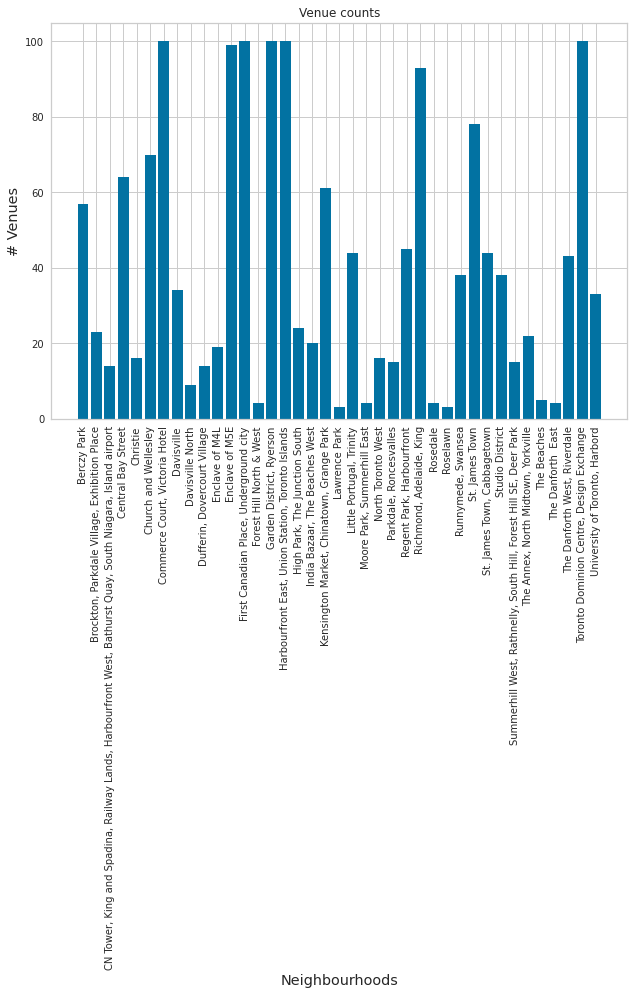

In [140]:
Toronto_counts = Toronto_venues.groupby('Neighborhood').count()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(Toronto_counts.index,Toronto_counts.Venue)
plt.xticks(Toronto_counts.index, rotation=90)
# Add title and axis names
plt.title('Venue counts')
plt.xlabel('Neighbourhoods', fontsize='large')
plt.ylabel('# Venues', fontsize='large')
plt.show()

# 3. Analyze each neighborhood

In [141]:
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Toronto_onehot.columns[-1]] + list(Toronto_onehot.columns[:-1])
Toronto_onehot = Toronto_onehot[fixed_columns]

Toronto_onehot.shape

(1575, 233)

In [142]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped.head()

,Neighborhood,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.017544,0.0,0.0,0.000000,0.0
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.071429,0.071429,0.071429,0.142857,0.142857,0.071429,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,Central Bay Street,0.015625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.015625,0.0,0.0,0.015625,0.0
4,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0


#### Let's find out the top 10  common venues across each neighborhood and Cluster them

In [143]:
#Function from the course
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Cheese Shop,Pharmacy,Seafood Restaurant,Beer Bar,Restaurant,Farmers Market,Concert Hall
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Coffee Shop,Convenience Store,Italian Restaurant,Stadium,Furniture / Home Store,Climbing Gym,Bar,Nightclub
2,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Harbor / Marina,Airport Food Court,Airport Gate,Airport Terminal,Sculpture Garden,Airport,Plane,Boat or Ferry
3,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Burger Joint,Bubble Tea Shop,Thai Restaurant,Department Store,Salad Place,Japanese Restaurant
4,Christie,Grocery Store,Café,Park,Coffee Shop,Nightclub,Baby Store,Italian Restaurant,Athletics & Sports,Restaurant,Candy Store


# 4. Clustering
After running the k-means clustering for a range of k, we now visualise the performance metrics for elbow method to choose the optimal value of k

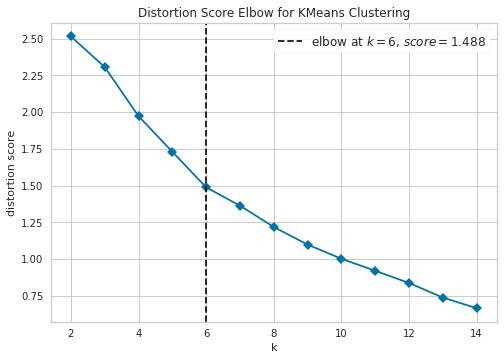

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [144]:
#!conda install -c conda-forge yellowbrick
from yellowbrick.cluster import KElbowVisualizer

#Find optimal number of clusters using the elbow method
Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,15), timings=False)

visualizer.fit(Toronto_grouped_clustering)        # Fit the data to the visualizer
visualizer.show() 

#### Result: As shown above, the elbow graph shows a elbow point at k=6 produces the local highest score. Therefor we choose K=6 to perform the final k-means clustering.

In [146]:
kclusters = 6
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

#### Now, we will add cluster Label to the dataset

In [147]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [148]:
Toronto_merged = canada_df1.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
Toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,1,Coffee Shop,Pub,Park,Bakery,Breakfast Spot,Theater,Café,French Restaurant,Chocolate Shop,Dessert Shop
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,1,Clothing Store,Coffee Shop,Italian Restaurant,Middle Eastern Restaurant,Cosmetics Shop,Café,Bubble Tea Shop,Bookstore,Japanese Restaurant,Hotel
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,1,Café,Coffee Shop,Cosmetics Shop,Cocktail Bar,Gastropub,Seafood Restaurant,Restaurant,Creperie,Lingerie Store,Moroccan Restaurant
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,4,1,Pub,Health Food Store,Pizza Place,Trail,Yoga Studio,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Miscellaneous Shop
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,1,1,Coffee Shop,Cocktail Bar,Bakery,Cheese Shop,Pharmacy,Seafood Restaurant,Beer Bar,Restaurant,Farmers Market,Concert Hall


# Visualise the clustering using Folium

In [149]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Finally lets print the individual clusters for further inspection

In [150]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Central Toronto,2,0,Mexican Restaurant,Trail,Jewelry Store,Sushi Restaurant,Yoga Studio,Movie Theater,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station


In [151]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,1,1,Coffee Shop,Pub,Park,Bakery,Breakfast Spot,Theater,Café,French Restaurant,Chocolate Shop,Dessert Shop
1,Downtown Toronto,1,1,Clothing Store,Coffee Shop,Italian Restaurant,Middle Eastern Restaurant,Cosmetics Shop,Café,Bubble Tea Shop,Bookstore,Japanese Restaurant,Hotel
2,Downtown Toronto,1,1,Café,Coffee Shop,Cosmetics Shop,Cocktail Bar,Gastropub,Seafood Restaurant,Restaurant,Creperie,Lingerie Store,Moroccan Restaurant
3,East Toronto,4,1,Pub,Health Food Store,Pizza Place,Trail,Yoga Studio,Moroccan Restaurant,Monument / Landmark,Molecular Gastronomy Restaurant,Modern European Restaurant,Miscellaneous Shop
4,Downtown Toronto,1,1,Coffee Shop,Cocktail Bar,Bakery,Cheese Shop,Pharmacy,Seafood Restaurant,Beer Bar,Restaurant,Farmers Market,Concert Hall
5,Downtown Toronto,1,1,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Burger Joint,Bubble Tea Shop,Thai Restaurant,Department Store,Salad Place,Japanese Restaurant
6,Downtown Toronto,1,1,Grocery Store,Café,Park,Coffee Shop,Nightclub,Baby Store,Italian Restaurant,Athletics & Sports,Restaurant,Candy Store
7,Downtown Toronto,1,1,Coffee Shop,Café,Restaurant,Thai Restaurant,Clothing Store,Deli / Bodega,Gym,Hotel,Concert Hall,Salad Place
8,West Toronto,3,1,Bakery,Pharmacy,Middle Eastern Restaurant,Bar,Music Venue,Supermarket,Café,Bank,Brewery,Park
10,Downtown Toronto,1,1,Coffee Shop,Aquarium,Café,Hotel,Restaurant,Scenic Lookout,Sporting Goods Shop,Brewery,Italian Restaurant,Fried Chicken Joint


In [152]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,East York/East Toronto,East York/East Toronto,2,Park,Convenience Store,Metro Station,Yoga Studio,Museum,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop
33,Downtown Toronto,1,2,Park,Playground,Trail,Yoga Studio,Movie Theater,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant


In [153]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 3, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Central Toronto,2,3,Garden,Fast Food Restaurant,Pool,Yoga Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop


In [154]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 4, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Central Toronto,2,4,Park,Bus Line,Swim School,Yoga Studio,Movie Theater,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant


In [155]:
Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 5, Toronto_merged.columns[[1] + list(range(5, Toronto_merged.shape[1]))]]

,Borough,Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Central Toronto,2,5,Restaurant,Lawyer,Trail,Tennis Court,Movie Theater,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant


# 5. Conclusion

### Cluster 0
These are neighborhoods mainly located outside of the touristic citycenter. and therefore less interesting for starting a restaurant for tourist and dayvisitors.

##### Could be a good fit for starting a restaurant for locals
 
### Cluster 1 
The most popular neighborhoods of the city. Plenty entertainment venues and fairly saturated with restaurants! 
#####  Hard areas to start new business and therefore not advisable

### Cluster 2
These are neighborhoods mainly surrounded by parks and therefore,

##### Could be a good fit for starting a restaurant for locals


### Cluster 3
Neighborhoods outside of the city center and low reachability by public transport. 

##### Low restaurant count but unpopular area for going out, therefore not advisable

### Cluster 4
Neighborhoods outside of the city center and low reachability by public transport. 

##### Low restaurant count but unpopular area for going out, therefore not advisable


### Cluster 5
Neighborhoods outside of the city center and low reachability by public transport. 

##### Low restaurant count but unpopular area for going out, therefore not advisable